In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

import seaborn as sns

In [2]:
palette = sns.color_palette('viridis', n_colors=8)
palette

[(0.281412, 0.155834, 0.469201),
 (0.244972, 0.287675, 0.53726),
 (0.190631, 0.407061, 0.556089),
 (0.147607, 0.511733, 0.557049),
 (0.119699, 0.61849, 0.536347),
 (0.20803, 0.718701, 0.472873),
 (0.430983, 0.808473, 0.346476),
 (0.709898, 0.868751, 0.169257)]

# Within-host model

\begin{align}
\dot V &= pV\left(1 - \frac{V}{K}\right) - c_T VT - cV \\
\dot T &= s_T + rT \left ( \frac{V^2}{V^2 + k_T^2}\right) - \delta_T T \\
\end{align}

In [60]:
def within_model(Y, t, p, K, c_T, c, d, r, k_T):
    V, T = Y
    T0 = 1e6
    
    dV = p*V*(1 - V/K) - c_T*V*T - c*V
    dT = d*T0 + r*T*(V**2/(V**2 + k_T**2)) - d*T
    
    return [dV, dT]

In [61]:
p = 5.01
K = 10**7.2979
c_T = 1e-6
c = 2.4
d = 0.1
r = 0.316
k_T = 5.01e5

In [62]:
names=['p', 'K', 'c_T', 'c', 'd', 'r', 'k_T']

In [63]:
dfGroundPars = pd.DataFrame([p, K, c_T, c, d, r, k_T]).T
dfGroundPars.columns = names

In [64]:
dfGroundPars

,p,K,c_T,c,d,r,k_T
0,5.01,1.985638e+07,0.000001,2.4,0.1,0.316,501000.0


## Simulation

In [65]:
V_0 = 0.31
T_0 = 1e6
Y0 = [V_0, T_0,]

t = np.linspace(-3, 23, 105)
dt = t[1]-t[0]

In [66]:
dt

0.25

In [67]:
sol = odeint(within_model, Y0, t, args=(p, K, c_T, c, d, r, k_T))

In [68]:
V_g = sol[:,0]
T_g = sol[:,1]

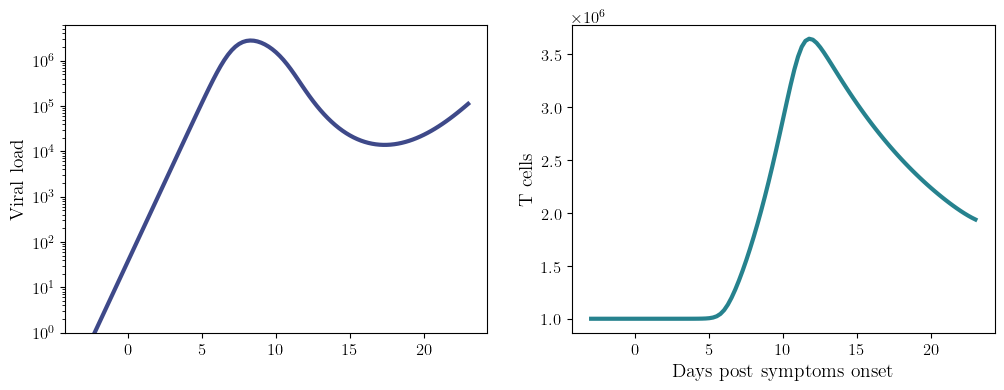

In [69]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4), facecolor='white')

axs[0].plot(t, V_g, lw=3, color=palette[1])
axs[0].set_ylabel('Viral load')
axs[0].set_yscale('log')
axs[0].set_ylim((1))

axs[1].plot(t, T_g, lw=3, color=palette[3])
axs[1].set_xlabel('Days post symptoms onset')
axs[1].set_ylabel('T cells')

plt.show()

# Recovering parameters
## Qualitative X3

In [86]:
dfData = pd.read_csv('covid-19/E-viral_load.data', sep=' ')
dfQual = pd.read_csv('covid-19/cd8_sev.data', sep=' ')

In [87]:
dfParams = pd.read_csv('covid-19/bestPars_noQual.dat', sep=' ', names=names)

In [88]:
V_0 = 0.31
T_0 = 1e6
Y0 = [V_0, T_0,]

t = np.linspace(-3, 23, 105)
dt = t[1]-t[0]

In [89]:
V = []
T = []
for i in range(dfParams.shape[0]):
    p = dfParams['p'][i]
    K = dfParams['K'][i]
    c_T = dfParams['c_T'][i]
    c = dfParams['c'][i]
    d = dfParams['d'][i]
    r = dfParams['r'][i]
    k_T = dfParams['k_T'][i]

    sol = odeint(within_model, Y0, t, args=(p, K, c_T, c, d, r, k_T))
    V.append(sol[:,0])
    T.append(sol[:,1])

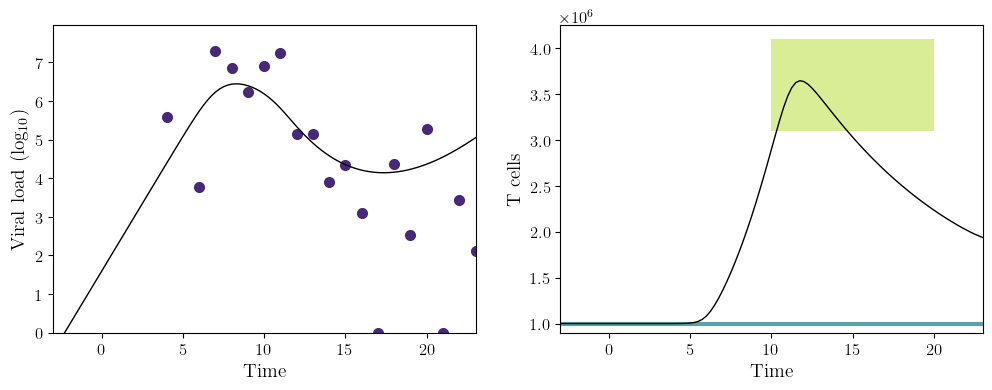

In [90]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,4), facecolor='white')

for i in range(dfParams.shape[0]):
    axs[0].plot(t, np.log10(V[i]), lw=3, color=palette[1], alpha=0.75)
    axs[1].plot(t, T[i], lw=3, color=palette[3], alpha=0.75)


axs[0].scatter(x=dfData['Time'], y=np.log10(dfData['V']), color=palette[0], lw=2)

timeWindow = 10
valueWindow = 1e6
for i in range(len(dfQual['Time'])):
    rect = plt.Rectangle((dfQual['Time'].values[i]- timeWindow/2, dfQual['T'].values[i] - valueWindow/2),
                         timeWindow, valueWindow, fc=palette[7], alpha = 0.5)
    axs[1].add_patch(rect)

axs[0].plot(t, np.log10(V_g), lw=1, color='k')
axs[0].set_ylim((0))
axs[1].plot(t, T_g, lw=1, color='k')
axs[1].set_ylim((0.9e6))

axs[0].set_ylabel('Viral load (log$_{10}$)')
axs[1].set_ylabel('T cells')

plt.setp(axs, xlim=(-3,23), xlabel='Time')

plt.show()

In [18]:
df1 = dfParams.melt(var_name='Parameters', value_name='Values')

In [19]:
df2 = dfGroundPars.melt(var_name='Parameters', value_name='Values')

<Axes: xlabel='Parameters', ylabel='Values'>

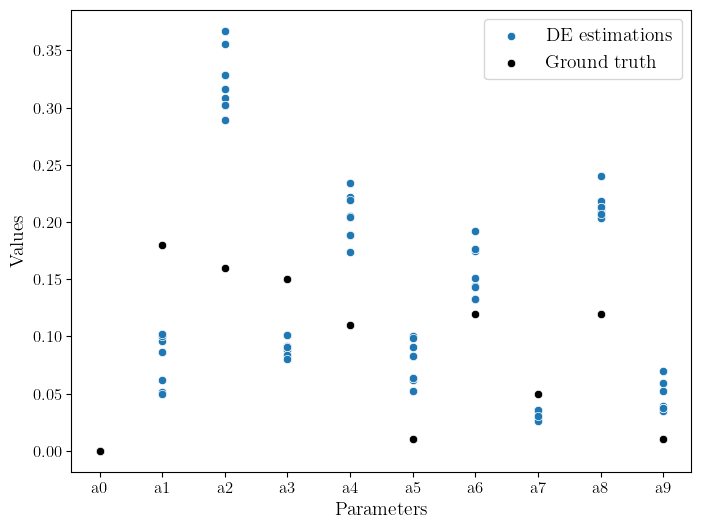

In [20]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8,6), facecolor='white')

sns.scatterplot(df1, x='Parameters', y='Values', label='DE estimations')
sns.scatterplot(df2, x='Parameters', y='Values', label='Ground truth', color='k')